# Lake-size distribution (LSD) scale comparison.

Goal: to load lake maps from the same region at two scale (HR and LR) and predict the small water body coverage (defined as area < 0.001 or 0.01 km2) from the LR dataset and physiographic region (with uncertainty).

Steps:
1. plot both LSD as survivor functions in log-log space (see functions from TGRS paper)

In [54]:
import os
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import Colormap
import matplotlib.colors as colors
import matplotlib
import matplotlib.mlab as mlab
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.ndimage as ndi 
from scipy.io import loadmat
from scipy.stats import binned_statistic
import pandas as pd
import geopandas as gpd
import pyogrio
import powerlaw
from tqdm import tqdm
## Plotting style
# plt.style.use('/mnt/c/Users/ekyzivat/Dropbox/Python/Matplotlib-rcParams/presentation.mplstyle')
# %matplotlib inline

## Plotting params
sns.set_theme('notebook', font='Ariel')
sns.set_style('ticks')


In [34]:
## I/O
gdf_bawld_pth = '/mnt/g/Other/Kuhn-olefeldt-BAWLD/BAWLD/BAWLD_V1___Shapefile.zip'
gdf_HL_jn_pth = '/mnt/g/Ch4/GSW_zonal_stats/HL/v3/HL_zStats_Oc_binned_jnBAWLD.shp' # HL clipped to BAWLD

# PeRL data exploration

In [2]:
# Inputs
perl_landscape_pth = '/mnt/f/PeRL/PeRL_permafrost_landscapes/PeRL_perma_land.shp'

In [3]:
df_perl_ls = gpd.read_file(perl_landscape_pth) # NOTE these following params apply to pandas:, dtype = {'frac_re': float}, na_values='NA') #, na_values='NA')
df_perl_ls.dropna(inplace=True) # dropping rows with no pond estimation - still keeps some regions with fraction data but no confidence intervals - comment out if using as a spatial index to load regional lake maps

## Clean up formatting for summary stats parsing
for var in ['frac_re', 'dens_re','dens_po_re', 'frac_po_re']:
    df_perl_ls[var] = pd.to_numeric(df_perl_ls[var],errors = 'coerce')
df_perl_ls.replace('NA',np.NaN, inplace=True)

## Add stat for ponds as fraction of water bodies
df_perl_ls['frac_ponds_norm'] = df_perl_ls.frac_ponds / df_perl_ls.frac * 100

## Describ
df_perl_ls.describe()
# df_perl_ls.info()
# df_perl_ls.dens_re

,PERMID,ECOZID,AREA,PERIMETER,confidence,frac,frac_re,dens,dens_re,frac_ponds,dens_ponds,dens_po_re,frac_po_re,area_km2,frac_ponds_norm
count,9.000000e+01,90.000000,9.000000e+01,9.000000e+01,90.000000,90.000000,56.000000,90.000000,56.000000,90.000000,90.000000,56.000000,56.000000,90.000000,90.000000
mean,1.720005e+08,167.788889,1.760757e+10,2.464504e+06,1.622222,7.745196,9.271695,13.054049,14.871469,1.118476,12.234809,16.428462,11.948254,17607.570278,15.180540
std,7.600753e+07,79.958767,3.173236e+10,3.644236e+06,0.487548,3.984106,7.506312,13.616041,16.737072,1.008503,13.507027,17.699687,10.748142,31732.362649,13.226395
min,1.003901e+08,102.000000,9.206387e+04,1.700568e+03,1.000000,1.082965,1.404741,0.967059,1.711065,0.043382,0.722353,1.227089,1.715034,0.092000,0.811064
25%,1.227674e+08,112.000000,1.255820e+09,3.940341e+05,1.000000,4.966632,3.849780,2.870042,3.409839,0.380385,2.307509,3.775760,3.289065,1255.820250,7.545870
50%,1.307571e+08,123.000000,5.737036e+09,1.255623e+06,2.000000,7.053175,5.748016,6.962368,7.596801,0.764033,5.619739,9.314350,5.482510,5737.036000,10.437574
75%,2.113740e+08,211.750000,1.870556e+10,3.456383e+06,2.000000,9.899185,11.837370,23.080014,18.855585,1.553638,22.045021,21.548837,16.443220,18705.563750,21.225034
max,3.080753e+08,307.000000,1.996447e+11,2.902694e+07,2.000000,21.107333,28.139881,57.045118,53.156887,5.880267,56.670111,55.856056,32.925706,199644.706000,56.612255


(0.0, 25.0)

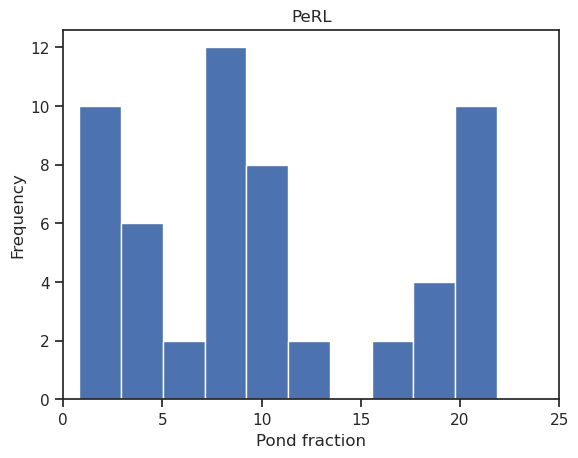

In [4]:
df_perl_ls.dropna().frac_ponds_norm.plot.hist()
plt.title('PeRL')
plt.xlabel('Pond fraction')
plt.xlim([0, 25])

# CIR LSD analysis

In [5]:
## Inputs
lsd_cir_pth = '/mnt/g/Planet-SR-2/Classification/cir/dcs_fused_hydroLakes_buf_10_sum.shp'
gdf_cir_lsd = gpd.read_file(lsd_cir_pth) 
gdf_cir_lsd.head()


,Join_Count,TARGET_FID,Area,RiverDomin,Category4,Region4,OID_,JOIN_FID,geometry
0,1,0,0.011819,0,1,12,1,0,"POLYGON ((-680953.719 1387817.517, -680953.420..."
1,1,1,0.006978,0,1,12,2,1,"POLYGON ((-681991.719 1387821.517, -681991.402..."
2,1,2,0.259890,0,1,12,3,2,"POLYGON ((-681504.361 1387932.796, -681503.668..."
3,1,3,0.001193,0,1,12,4,3,"POLYGON ((-680021.532 1387963.352, -680021.908..."
4,1,4,0.001669,0,1,12,5,4,"POLYGON ((-681108.187 1388031.354, -681108.719..."


In [6]:
gdf_cir_lsd.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 43562 entries, 0 to 43561
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Join_Count  43562 non-null  int64   
 1   TARGET_FID  43562 non-null  int64   
 2   Area        43562 non-null  float64 
 3   RiverDomin  43562 non-null  int64   
 4   Category4   43562 non-null  int64   
 5   Region4     43562 non-null  int64   
 6   OID_        43562 non-null  int64   
 7   JOIN_FID    43562 non-null  int64   
 8   geometry    43562 non-null  geometry
dtypes: float64(1), geometry(1), int64(7)
memory usage: 3.0 MB


In [7]:
## Add region to gdf
regions = ['Sagavanirktok River', 'Yukon Flats Basin', 'Old Crow Flats', 'Mackenzie River Delta', 'Mackenzie River Valley', 'Canadian Shield Margin', 'Canadian Shield', 'Slave River', 'Peace-Athabasca Delta', 'Athabasca River', 'Prairie Potholes North', 'Prairie Potholes South', 'Tuktoyaktuk Peninsula', 'All']
# gdf_cir_lsd['Region'] = regions[gdf_cir_lsd['Region4']-2]
# gdf_cir_lsd.apply(Region = lambda x: x.Region4, axis=1) # (regions[x['Region4']-2]) # regions[x.Region4]
# gdf_cir_lsd['Region'].head()
for idx in gdf_cir_lsd.index: # slow, non-vectorized way...
    gdf_cir_lsd.loc[idx, 'Region'] = regions[gdf_cir_lsd.loc[idx, 'Region4']-2]
gdf_cir_lsd.head()

,Join_Count,TARGET_FID,Area,RiverDomin,Category4,Region4,OID_,JOIN_FID,geometry,Region
0,1,0,0.011819,0,1,12,1,0,"POLYGON ((-680953.719 1387817.517, -680953.420...",Prairie Potholes North
1,1,1,0.006978,0,1,12,2,1,"POLYGON ((-681991.719 1387821.517, -681991.402...",Prairie Potholes North
2,1,2,0.259890,0,1,12,3,2,"POLYGON ((-681504.361 1387932.796, -681503.668...",Prairie Potholes North
3,1,3,0.001193,0,1,12,4,3,"POLYGON ((-680021.532 1387963.352, -680021.908...",Prairie Potholes North
4,1,4,0.001669,0,1,12,5,4,"POLYGON ((-681108.187 1388031.354, -681108.719...",Prairie Potholes North


In [94]:
## Cycle through 14 regions V2
df_cir_rec = pd.DataFrame(columns = ['Region_ID', 'Region', 'Lake_area', 'stat', 'A_0.001', 'A_0.001_cor', 'A_0.01_cor', 'A_0.01', 'A_g100m', 'A_g1', 'PeRL_pnd_f']) # cir recomputed, for double checking A_0.001 from paper; A_0.001_cor excludes the largest lakes like in PeRL, but uses native CIR min size of 40 m2; computing A_0.01 analogous to PeRL pond fraction, PeRL_pnd for equivalent to perl analysis (min is 100 m2, max is 1 km2), A_g100m, for lakes > 100 m2, analogous to PeRL, F_g1 for area of lakes larger than PeRL maximum size, 'PeRL_all' to simulate perl size domain, and 'PeRL_pnd_f' which is perl pond divided perl all # 'PeRL_pnd', 'PeRL_all'
for i, region in enumerate(range(2, 16)): # no region 1
    if region!=15: 
        gdf_tmp = gdf_cir_lsd.query('Region4 == @region')
    else:
        gdf_tmp = gdf_cir_lsd # compute over all
    df_cir_rec.loc[i, 'Region_ID'] = region
    df_cir_rec.loc[i, 'Region'] = regions[i]
    df_cir_rec.loc[i, 'Lake_area'] = gdf_tmp.Area.sum()
    df_cir_rec.loc[i, 'A_0.001'] = gdf_tmp.query('(Area < 0.001)').Area.sum() / df_cir_rec.loc[i, 'Lake_area'] * 100
    df_cir_rec.loc[i, 'A_0.001_cor'] = gdf_tmp.query('(Area < 0.001)').Area.sum() / gdf_tmp.query('(Area < 1)').Area.sum() * 100
    df_cir_rec.loc[i, 'A_0.01_cor'] = gdf_tmp.query('(Area < 0.01)').Area.sum() / gdf_tmp.query('(Area < 1)').Area.sum() * 100
    df_cir_rec.loc[i, 'A_0.01'] = gdf_tmp.query('(Area < 0.01)').Area.sum() / df_cir_rec.loc[i, 'Lake_area'] * 100
    df_cir_rec.loc[i, 'A_g1'] = gdf_tmp.query('(Area >= 1)').Area.sum() / df_cir_rec.loc[i, 'Lake_area'] * 100    
    df_cir_rec.loc[i, 'A_g100m'] = gdf_tmp.query('(Area >= 0.0001)').Area.sum() / df_cir_rec.loc[i, 'Lake_area'] * 100
    df_cir_rec.loc[i, 'PeRL_pnd_f'] = gdf_tmp.query('(Area >= 0.0001) and  (Area < 0.01)').Area.sum() / \
         gdf_tmp.query('(Area >= 0.0001) and  (Area < 1)').Area.sum() * 100
    df_cir_rec.loc[i, 'HL_pnd_f_4'] = gdf_tmp.query('(Area >= 0.0001) and  (Area < 0.1)').Area.sum() / \
        gdf_tmp.query('(Area >= 0.0001) and  (Area < 1)').Area.sum() * 100 # Pond fraction, as defined by HydroLakes lower limit and upper limit defined by CIR # 4 means that lower limit is 10^-4
    df_cir_rec.loc[i, 'HL_pnd_r_4'] = gdf_tmp.query('(Area >= 0.0001) and  (Area < 0.1)').Area.sum() / \
        gdf_tmp.query('(Area >= 0.1) and  (Area < 1)').Area.sum() * 100 # Pond fraction, as defined by HydroLakes lower limit and upper limit defined by CIR (fraction, not ratio, so it can be used as divident for extrapolation from mid lakes)
    df_cir_rec.loc[i, 'HL_pnd_r_3'] = gdf_tmp.query('(Area >= 0.001) and  (Area < 0.1)').Area.sum() / \
        gdf_tmp.query('(Area >= 0.1) and  (Area < 1)').Area.sum() * 100 # to compare to WBD
    df_cir_rec.loc[i, 'HL_pnd_r_2'] = gdf_tmp.query('(Area >= 0.01) and  (Area < 0.1)').Area.sum() / \
        gdf_tmp.query('(Area >= 0.1) and  (Area < 1)').Area.sum() * 100 # to compare to Sheng

## Re-index
df_cir_rec.set_index('Region', inplace=True)

## View
df_cir_rec[['A_0.001_cor', 'A_0.01', 'A_0.01_cor', 'PeRL_pnd_f']]

,A_0.001_cor,A_0.01,A_0.01_cor,PeRL_pnd_f
Region,,,,
Sagavanirktok River,3.031203,10.395833,10.395833,10.185303
Yukon Flats Basin,0.99283,5.839131,7.522919,7.472215
Old Crow Flats,0.195526,0.654397,1.837864,1.825564
Mackenzie River Delta,0.396733,2.067478,3.93086,3.907932
Mackenzie River Valley,0.863484,1.176034,6.227916,6.160738
Canadian Shield Margin,1.33229,0.197271,8.305,8.246269
Canadian Shield,0.247682,0.191295,2.25814,2.239487
Slave River,4.147409,17.321269,23.358883,23.093916
Peace-Athabasca Delta,2.832858,1.03603,13.606928,13.368182


Median pond fraction for CIR: 6.8164765870156145

{'HL_pnd_r_4': 39.86573106442521, 'HL_pnd_r_3': 38.777843850303476, 'HL_pnd_r_2': 32.451407244601164}


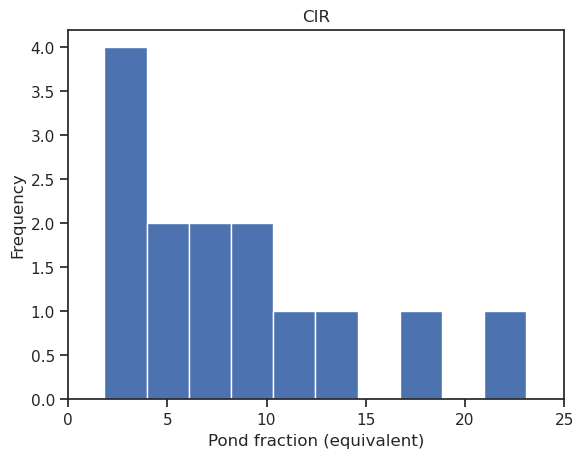

In [95]:
## CIR hist and calculate median pond fractions
df_cir_rec.PeRL_pnd_f.plot.hist()
plt.title('CIR')
plt.xlabel('Pond fraction (equivalent)')
plt.xlim([0, 25])
perl_pond_frac_cir = df_cir_rec.PeRL_pnd_f.median()
print(f'Median pond fraction for CIR: {perl_pond_frac_cir}')
# hl_pond_frac_cir = df_cir_rec.HL_pnd_f.median()
# print(f'Median HL pond fraction for CIR: {hl_pond_frac_cir}')
print('')

## Dictionary with ratios
ratio_dict = {
    'HL_pnd_r_4': df_cir_rec.loc[ 'All', 'HL_pnd_r_4'],
    'HL_pnd_r_3': df_cir_rec.loc[ 'All', 'HL_pnd_r_3'],
    'HL_pnd_r_2': df_cir_rec.loc[ 'All', 'HL_pnd_r_2']
    }
print(ratio_dict)

## CDF plots

<AxesSubplot:xlabel='Area', ylabel='Probability'>

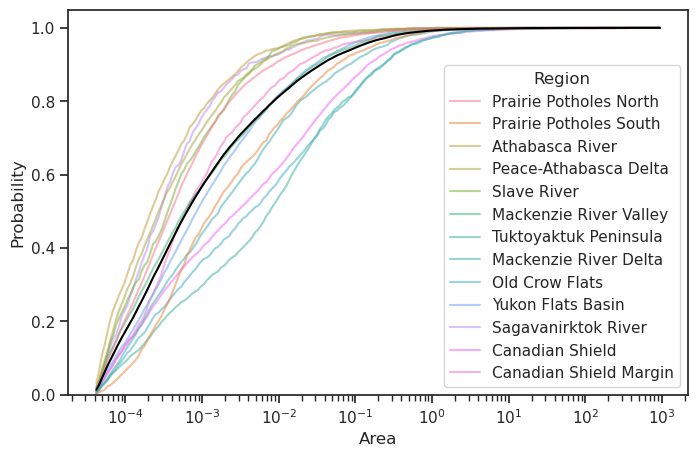

In [10]:
fig, ax = plt.subplots(figsize=(8,5)) # size=(5,3)
sns.histplot(data=gdf_cir_lsd, x="Area", hue="Region", element="poly", log_scale=True, bins=200, palette=None, stat='probability', cumulative=True, common_norm=False, fill=False, alpha=0.5, ax=ax) # 
sns.histplot(data=gdf_cir_lsd, x="Area", color='black', element="poly", log_scale=True, bins=200, palette=None, stat='probability', cumulative=True, common_norm=False, fill=False, ax=ax, label='All') # 
# ax.set_yscale('log')

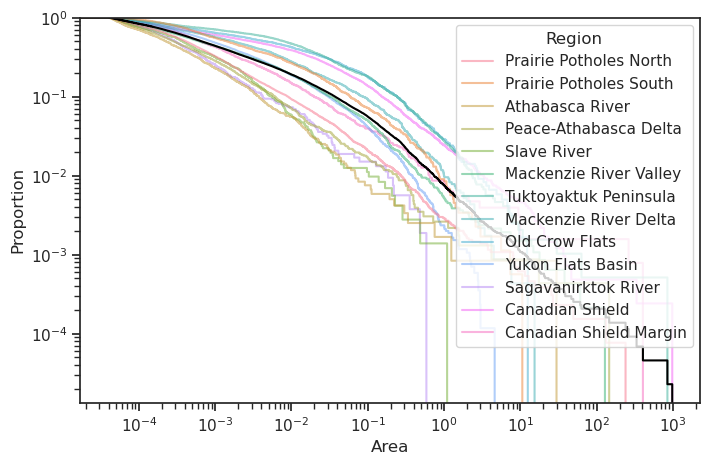

In [11]:
fig, ax = plt.subplots(figsize=(8,5)) # size=(5,3)
sns.ecdfplot(data=gdf_cir_lsd, complementary=True, x="Area", hue="Region", log_scale=True, alpha=0.5, ax=ax) # 
sns.ecdfplot(data=gdf_cir_lsd, complementary=True, x="Area", color='black', log_scale=True, ax=ax, label='All') # 
ax.set_yscale('log')

Text(0.5, 0, 'Lake area')

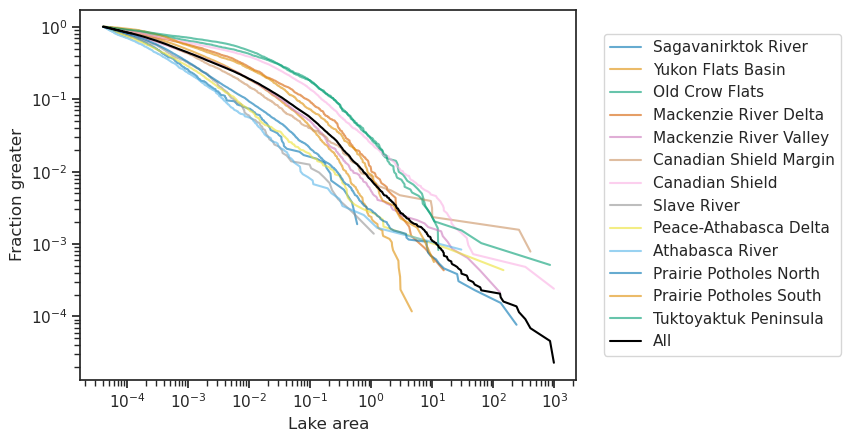

In [12]:
## Powerlaw package plots: CDF doesn't use binning

## colors
# rainbow_cycler = cycler
sns.set_palette("colorblind",len(regions) ) # colors from https://stackoverflow.com/a/46152327/7690975 Other option is: `from cycler import cycler; `# ax.set_prop_cycle(rainbow_cycler), plt(... prop_cycle=rainbow_cycler, )

## plot
fig, ax = plt.subplots() # figsize=(5,3)
for region in regions[:-1]:
    powerlaw.plot_cdf(gdf_cir_lsd.query('Region == @region').Area, alpha=0.6, survival=True, ax=ax, label=region) # color='green' # 

powerlaw.plot_cdf(gdf_cir_lsd.Area, survival=True, ax=ax, color='black', label='All')
ax.legend(loc= 'center left', bbox_to_anchor=(1.04, 0.5)) # legend on right (see https://stackoverflow.com/a/43439132/7690975)
ax.set_ylabel('Fraction greater')
ax.set_xlabel('Lake area')


In [ ]:
def findNearest(arr, val):
    ''' Function to find index of value nearest to target value'''
    # calculate the difference array
    difference_array = np.absolute(arr-val)
    
    # find the index of minimum element from the array
    index = difference_array.argmin()
    return index

Text(0.5, 0, 'Lake area')

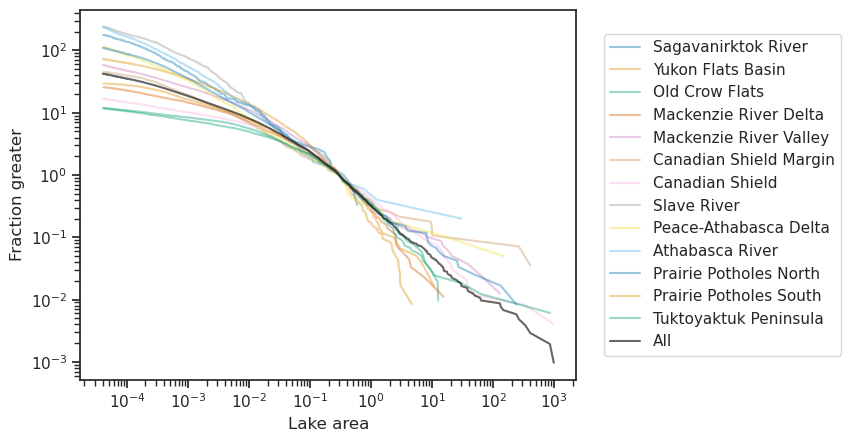

In [30]:
## Repeat, but apply offset based on value at 0.3 km2 to match up on high end

## colors
# rainbow_cycler = cycler
sns.set_palette("colorblind",len(regions) ) # colors from https://stackoverflow.com/a/46152327/7690975 Other option is: `from cycler import cycler; `# ax.set_prop_cycle(rainbow_cycler), plt(... prop_cycle=rainbow_cycler, )

## plot
fig, ax = plt.subplots() # figsize=(5,3)
for region in regions[:-1]:
    X, P = powerlaw.cdf(gdf_cir_lsd.query('Region == @region').Area, survival=True) # color='green' # 
    idx = findNearest(X, 0.3)
    ax.plot(X, P/(P[idx]), alpha=0.4, label=region)

## repeat for all (should re-use as function...)
X, P = powerlaw.cdf(gdf_cir_lsd.Area, survival=True)
idx = findNearest(X, 0.3)
ax.plot(X, P/(P[idx]), alpha=0.6, color='black', label='All')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc= 'center left', bbox_to_anchor=(1.04, 0.5)) # legend on right (see https://stackoverflow.com/a/43439132/7690975)
ax.set_ylabel('Fraction greater')
ax.set_xlabel('Lake area')

# Calculate means and uncertainties for pond percentage from BAWLD

In [68]:
gdf = gpd.read_file(gdf_bawld_pth)
df = pyogrio.read_dataframe(gdf_HL_jn_pth, columns=['BAWLDCell_', 'Shp_Area', 'BAWLDLong', 'BAWLDLat'], read_geometry=False, use_arrow=True)
print(df.head(2))
print(gdf.head(2))

   Shp_Area  BAWLDCell_  BAWLDLong  BAWLDLat
0  30450.64       11887    -122.25     65.75
1  26734.29        7387    -113.25     61.75
   Cell_ID    Long    Lat  Area_Pct      Shp_Area  GLA    ROC    TUN    BOR  \
0     7265  165.75  61.25     100.0  1.495458e+09  0.0  35.26  48.78  14.92   
1    14494   61.25  67.75     100.0  1.178664e+09  0.0   0.00  64.31   0.00   

     WET  ...  RIV_L  RIV_H  LAR_L  LAR_H  SRR_L  SRR_H  SRP_L  SRP_H  \
0   0.80  ...   0.09   0.24    0.0    0.0   0.00   0.05   0.23   0.39   
1  32.04  ...   0.14   0.38    0.0    0.0   0.01   0.28   0.00   0.12   

   WETSCAPE                                           geometry  
0        11  POLYGON ((774650.577 3106953.763, 801734.023 3...  
1         1  POLYGON ((2193307.808 -1190868.976, 2182832.13...  

[2 rows x 73 columns]


In [64]:
ratio_dict

{'HL_pnd_r_4': 47.202475610866564,
 'HL_pnd_r_3': 44.55122731560468,
 'HL_pnd_r_2': 34.235847643978744}

In [96]:
# Loop
for i in tqdm(range(len(gdf))): # 10 # len(gdf)
    ## Select only lakes in cell (based on pour point)
    cell_id = gdf.loc[i, 'Cell_ID'] # called BAWLD_Cell in df
    df_tmp = df.query(f'BAWLDCell_==@cell_id')

    ## compute area stats
    gdf.loc[i, 'HL_area'] = df_tmp.Shp_Area.sum() # all HL-observable lakes
    gdf.loc[i, 'Ppnd_area'] = df_tmp.query('(Shp_Area >= 0.0001) and  (Shp_Area < 0.01)').Shp_Area.sum() # perl ponds (will always be 0 for HL)
    gdf.loc[i, 'Plk_area'] = df_tmp.query('(Shp_Area >= 0.01) and  (Shp_Area < 1)').Shp_Area.sum() # perl lakes (not ponds)
    gdf.loc[i, 'Mid_lk_area'] = df_tmp.query('(Shp_Area >= 0.1) and  (Shp_Area < 1)').Shp_Area.sum() # Mid lakes (if I used 0.3 cutoff, I could include all CIR sites) to use for extrapolation
    gdf.loc[i, 'Lg_lk_area'] = df_tmp.query('(Shp_Area >= 1)').Shp_Area.sum() # Large lakes (add to extrapolation)
    gdf.loc[i, 'Hpnd_extrap4'] = (1 + ratio_dict['HL_pnd_r_4'] / 100) * gdf.loc[i, 'Mid_lk_area'] + gdf.loc[i, 'Lg_lk_area']
    gdf.loc[i, 'Hpnd_extrap3'] = (1 + ratio_dict['HL_pnd_r_3'] / 100) * gdf.loc[i, 'Mid_lk_area'] + gdf.loc[i, 'Lg_lk_area']
    gdf.loc[i, 'Hpnd_extrap2'] = (1 + ratio_dict['HL_pnd_r_2'] / 100) * gdf.loc[i, 'Mid_lk_area'] + gdf.loc[i, 'Lg_lk_area']
    gdf.loc[i, 'Meg_lk_area'] = df_tmp.query('(Shp_Area >= 5000)').Shp_Area.sum() # Mega lakes (often subtracted from upscaling)

gdf.head()

100%|██████████| 23469/23469 [04:16<00:00, 91.51it/s]


,Cell_ID,Long,Lat,Area_Pct,Shp_Area,GLA,ROC,TUN,BOR,WET,...,geometry,HL_area,Ppnd_area,Plk_area,Mid_lk_area,Lg_lk_area,Hpnd_extrap4,Hpnd_extrap3,Hpnd_extrap2,Meg_lk_area
0,7265,165.75,61.25,100.00,1.495458e+09,0.0,35.26,48.78,14.92,0.80,...,"POLYGON ((774650.577 3106953.763, 801734.023 3...",0.00,0.0,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.0
1,14494,61.25,67.75,100.00,1.178664e+09,0.0,0.00,64.31,0.00,32.04,...,"POLYGON ((2193307.808 -1190868.976, 2182832.13...",9.20,0.0,0.78,0.78,8.42,9.510953,9.502467,9.453121,0.0
2,3598,51.25,57.25,42.39,7.103697e+08,0.0,0.00,0.00,91.04,8.81,...,"POLYGON ((2800176.939 -2227361.310, 2816190.99...",0.33,0.0,0.33,0.33,0.00,0.461557,0.457967,0.437090,0.0
3,4863,122.25,58.75,100.00,1.612116e+09,0.0,0.00,0.00,96.13,3.72,...,"POLYGON ((2927361.809 1864935.151, 2943524.767...",0.00,0.0,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.0
4,19124,-99.25,73.25,100.00,8.978315e+08,0.0,31.62,63.32,0.00,2.96,...,"POLYGON ((-1865353.640 312153.145, -1810905.60...",18.56,0.0,4.99,4.99,13.57,20.549300,20.495014,20.179325,0.0


/tmp/ipykernel_4323/2443366505.py:3: FutureWarning: The default value of numeric_only in GeoDataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  sums = gdf.sum()


Text(0, 0.5, 'Total lake area ($km^2$)')

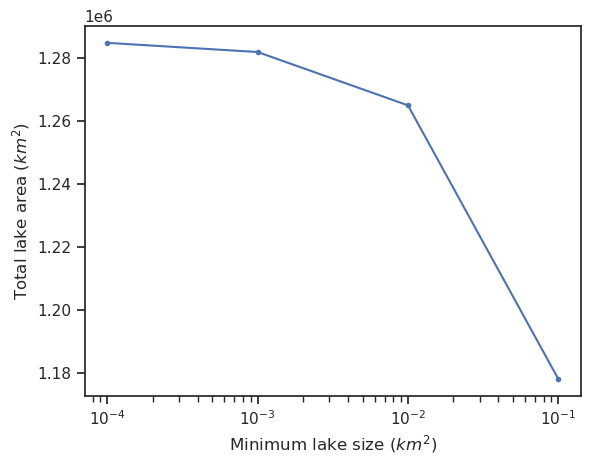

In [97]:
## Plot total area as function of extrapolated min. size

sums = gdf.sum()
plt.plot([0.1, 0.01, 0.001, 0.0001], [sums.HL_area, sums.Hpnd_extrap2, sums.Hpnd_extrap3, sums.Hpnd_extrap4], '.-')
plt.xscale('log')
plt.xlabel('Minimum lake size ($km^2$)')
plt.ylabel('Total lake area ($km^2$)')

TODO: 
* make equivalence to hl_pond_frac_cir
* [try using numba to accelerate?]
* save 1 vs. 0.3 cutoff as var
* add std or CI
* write out
* find a way to relate to flux estimates

# HR16 scaling

In [3]:
## Inputs
lsd_pth='/mnt/d/GoogleDrive/Research/Lake distributions/savedData/fitting_data_regional_4_det.mat' # these directories hold the final version of data used for 2019 paper
lsd_labels_pth='/mnt/d/GoogleDrive/Research/Lake distributions/regionLabels4.mat'

In [7]:
# fluxes={'OW': 100,
#        'GW': 300,
#        'SW': 200}

FRACTION={
    'IN_TOTAL':(
    (22, 31),
    (10,16),
    (27, 30),
    (37.4, 37.6),
    (10, 37.6)), # Default Fraction Inundated; From Run 35
    'EM':((35, 58),
     (42, 60),
     (12, 21),
     (2, 2.5),
     (0, 100)) #(2, 30) # Default Fraction macrophyte: From Run 35 (range: 2:60)
}
FLUXES={
    'OW': (0, 166), # Open water; From range in: Burger et al 2016	Biogeosciences | Superceded if using LSD
    'EM': (77, 2000), # (77, 3000) #(77, 380)  # Emergent macrophyte; From mean (max = 5800) in: Burger et al 2016	Biogeosciences
    'RATIO': (0, 4000) # based on second and third- highest values of ~170x (0, 200)
}
    # Sensitivity raster dimensions
FRACTION_STEPS=100 # 40
FLUX_STEPS=100 # 40
SITES=('PAD','YFB','YKN','DAR','All') #short names for sites
SITES_LSD = (9,2,7,7,0) # numbers as givin in Lake Size Distribution files
# REGION=0 # Set to -1 if using default; 0=PAD

# LAT=59 # latitude, in degrees (PAD=59)

### Size binning data from Holgerson and Raymond 2016

In [9]:
BIN_EDGES=np.array([0, 0.001, 0.01, 0.1, 1, 10, 100, 1000000]) # <km2>
# BIN_EDGES=np.array([0.001, 0.01, 0.1, 1, 10, 100, 10000000]) * 1000000 # <km2> * 1000000 = <m2>
BIN_FLUXES=np.array([2.28, 0.65, 0.28, 0.16,  0.12, 0.10, 0.06])*16.043 # <mmolC (in CH4)/m2/d> * 16.043 = <mg CH4/m2/d>
len(BIN_FLUXES)

7

### Load data

In [10]:
fused_regional=loadmat(lsd_pth, variable_names='Fused_regional', squeeze_me=True)

##############
# for area for each region, see: D:\GoogleDrive\Research\Lake distributions\savedData\out
##############

### Create sensitivity raster

In [11]:
SENSITIVITY={}
FRACTION_POSTINGS={}
FLUX_POSTINGS={}
for si, s in enumerate(SITES):
    print('\nSite: {}'.format(s))
    lsd = fused_regional['Fused_regional'][SITES_LSD[si]] # Lake size distribution for chosen region
    SENSITIVITY[s]=np.zeros((FRACTION_STEPS, FLUX_STEPS), 'double') # init
    # lsd_tmp=lsd # init
    FRACTION_POSTINGS[s]=np.linspace(FRACTION['EM'][si][0], FRACTION['EM'][si][1], FRACTION_STEPS)
    for Class in FLUXES.keys():
        FLUX_POSTINGS[Class]=np.linspace(FLUXES[Class][0], FLUXES[Class][1], FLUX_STEPS)
    lsd_vals = binned_statistic(lsd, lsd, statistic='sum', bins=BIN_EDGES)
    ow_flux_mean=np.sum(lsd_vals.statistic*BIN_FLUXES)/lsd.sum()
    print(f'Open water flux used: {ow_flux_mean:.3} [mg CH_4 / m^2 / day]')
    print(f'EM fraction: {0:0.2f}%\t| Total W area in first bin: \t\
        {lsd_vals.statistic[0]*(100- 0)/100:.2f}\t| Total W area: {np.sum(lsd)*(100- 0)/100:.2f}\n')
    for i in range(FRACTION_STEPS):
        ##############################################
             # toggle if not using LSD
    #     ow_flux_mean=np.mean(FLUX_POSTINGS['OW'])
        ##############################################
            # toggle if using LSD | with lakes changing bins # Results in higher water flux in highest EM bin bc more of the lakes are now small (unrealistic)
    #     lsd_tmp_vals = binned_statistic(lsd_tmp, lsd_tmp, statistic='sum', bins=BIN_EDGES) # could also use np.digitize
    #     ow_flux_mean=np.sum(lsd_tmp_vals.statistic*BIN_FLUXES)/lsd_tmp.sum()
    #     print(f'EM fraction: {FRACTION_POSTINGS[i]:0.2f}%\t| Total W area in first bin: \
    #         {lsd_tmp_vals.statistic[0]:.2f}\t| Total W area: {np.sum(lsd_tmp_vals.statistic):.2f}\t| Total W flux: {((100- FRACTION_POSTINGS[i]) * ow_flux_mean) / 100:.2f}')
        ##############################################
            # toggle if using LSD | with lakes NOT changing bins # Results in lower water flux in highest EM bin
        print(f'EM fraction: {FRACTION_POSTINGS[s][i]:0.2f}%\t| Total W area in first bin: \
            {lsd_vals.statistic[0]*(100- FRACTION_POSTINGS[s][i])/100:.2f}\t| Total W area: \
            {np.sum(lsd_vals.statistic)*(100- FRACTION_POSTINGS[s][i])/100:.2f}\t| Total W flux: {((100- FRACTION_POSTINGS[s][i]) * ow_flux_mean) / 100:.2f}')
        ##############################################
        for j in range(FLUX_STEPS):
            # each cell = <region's inundation fraction> * (<EM fraction> * <EM flux> + <OW fraction> * <OW flux>)
            SENSITIVITY[s][i,j] = np.mean(FRACTION['IN_TOTAL'][si]) / 100 * (FRACTION_POSTINGS[s][i] * FLUX_POSTINGS['EM'][j] + # use median? # note: hard-coded for just two classes: OW and EM
                                (100- FRACTION_POSTINGS[s][i]) * ow_flux_mean) / 100
        


Site: PAD
Open water flux used: 1.36 [mg CH_4 / m^2 / day]
EM fraction: 0.00%	| Total W area in first bin: 	        0.40	| Total W area: 186.62

EM fraction: 35.00%	| Total W area in first bin:             0.26	| Total W area:             121.30	| Total W flux: 0.89
EM fraction: 35.23%	| Total W area in first bin:             0.26	| Total W area:             120.87	| Total W flux: 0.88
EM fraction: 35.46%	| Total W area in first bin:             0.26	| Total W area:             120.43	| Total W flux: 0.88
EM fraction: 35.70%	| Total W area in first bin:             0.26	| Total W area:             120.00	| Total W flux: 0.88
EM fraction: 35.93%	| Total W area in first bin:             0.26	| Total W area:             119.57	| Total W flux: 0.87
EM fraction: 36.16%	| Total W area in first bin:             0.26	| Total W area:             119.13	| Total W flux: 0.87
EM fraction: 36.39%	| Total W area in first bin:             0.26	| Total W area:             118.70	| Total W flux: 0.87


(0.0, 1000.0)

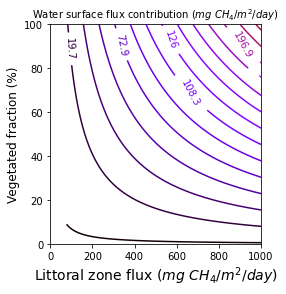

In [13]:
## Single contour plot
# %matplotlib inline
f=12 # fontsize
# num_contours = np.linspace(5, np.max(SENSITIVITY['All']), 11) #10
num_contours = np.linspace(2, 250, 15) #10

# Define a class that forces representation of float to look a certain way
# This remove trailing zero so '1.0' becomes '1'
class nf(float):
    def __repr__(self):
        str = '%.1f' % (self.__float__(),)
        if str[-1] == '0':
            return '%.0f' % self.__float__()
        else:
            return '%.1f' % self.__float__()
    # axis
fig, ax = plt.subplots(sharex=True, figsize=(4,4))

    # quick fix
# quick_title=SITES # keep unchanged
quick_title=['PAD','YF','CS-1','CS-2','All'] # keep unchanged

    # loop
for si, s in zip([4], ['All']):
        
        # define dims
    Y=FRACTION_POSTINGS[s]
    X=FLUX_POSTINGS['EM']
    Z=SENSITIVITY[s]
    
    # Basic contour plot
    CS = ax.contour(X, Y, Z, num_contours, cmap='gnuplot', vmin =0, vmax=500,
        extent=(FLUXES['EM'][0], FLUXES['EM'][1], FRACTION['EM'][si][0], FRACTION['EM'][si][1]))

    # Recast levels to new class
    CS.levels = [nf(val) for val in CS.levels]

    # Label levels with specially formatted floats
    if plt.rcParams["text.usetex"]:
        fmt = r'%r'
    else:
        fmt = '%r'
    ax.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10)
    ax.set_xlabel("Littoral zone flux ($mg\ CH_4 / m^2 /day$)", fontsize=f+2)
    ax.set_ylabel('Vegetated fraction (%)', fontsize=f)
#     fig.text(0.5, 0.04, "Littoral zone flux ($mg\ CH_4 / m^2 /day$)", ha='center', va='bottom', fontsize=f, FONTNAME='DejaVu Sans')
#     fig.text(0.04, 0.5, 'Vegetated fraction (%)', va='center', rotation='vertical', fontsize=f, FONTNAME='sans-serif')
#     ax.set_title(f'{quick_title[si]}: {np.mean(SENSITIVITY[s]):0.0f}', fontsize=f)
    fig.tight_layout()
    
## Superimpose errorbar plot: lit values
# ax.errorbar(FLUXES_LIT, FRACTION_LIT, FRACTION_LIT_CI,FLUXES_LIT_CI, 'ko', ecolor='gray', fillstyle='none', alpha=0.6) # , clip_box=(0,0,6000,100)

## Superimpose errorbar plot: field values
# ax.errorbar(FLUXES_FIELD, FRACTION_FIELD, FRACTION_FIELD_CI,FLUXES_FIELD_CI, 'bo', ecolor='#2D7DC4', fillstyle='none', alpha=0.6) # , clip_box=(0,0,6000,100)

## title
plt.title('Water surface flux contribution ($mg\ CH_4 / m^2 /day$)', fontsize=f-2)

## legend
# plt.legend(['Published data', 'Field data'], loc='best')

## set window
ax.set_xlim(0, 1000)

    # save
# figPth='/mnt/d/pic/UAVSAR_classification/upscaleSensitivityRasterContoursErrors.jpg'
# plt.savefig(figPth, dpi=300)
# figPth='/mnt/d/pic/UAVSAR_classification/upscaleSensitivityRasterContoursErrors.pdf'
# plt.savefig(figPth, dpi=300)

# print('Saved fig to:\t{}'.format(figPth))